# Init

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

# Q-Learning

In [12]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

In [13]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, gamma, alpha, epsilon, epsilon_min, epsilon_decay):
        self.n_states = n_states
        self.n_actions = n_actions
        self.GAMMA = gamma
        self.ALPHA = alpha
        self.EPSILON = epsilon
        self.epsilon_min = epsilon_min 
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((*n_states, n_actions))
        self.bins = self.create_bins()

    # e-GREEDY POLICY
    def get_action(self, state, greedy=False):
        if( (np.random.uniform() >= self.EPSILON) or greedy):
            action = np.argmax(self.Q[state])
        else:
            action = env.action_space.sample()
        return action
    
    # Q-Learning
    def update_q(self, state, action, reward, state_):
        actionMAX_ = np.argmax(self.Q[state_])
        qMAX_ = self.Q[state_][actionMAX_]
        self.Q[state][action] += (self.ALPHA * (reward + (self.GAMMA * qMAX_) - self.Q[state][action]))
        self.decay_epsilon()

    def decay_epsilon(self):
        if(self.EPSILON > self.epsilon_min):
            self.EPSILON = self.EPSILON * self.epsilon_decay
        else:
            self.EPSILON = self.epsilon_min

    # DISCRETIZING CONTINUOUS SPACE
    def create_bins(self):
        bins = [None] * 2
        bins[0] = np.linspace(-1.2, 0.6, self.n_states[0])
        bins[1] = np.linspace(-0.07, 0.07, self.n_states[1])
        return np.array(bins)

    # GIVEN OBSERVATION ARRAY AND BINS, RETURNS STATE NUMBER
    def get_state(self, observation):
        state = [None] * 2
        for i in range(2):
            state[i] = int(np.digitize(observation[i], self.bins[i]) - 1)
        return tuple(state)

In [14]:
#PLAY SINGLE EPISODE - Q-Learning
def play_episode(agent):
    total_reward = 0

    observation = env.reset()
    state = agent.get_state(observation)
    
    for moves in range(MAX_MOVES):
        # e-GREEDY
        action = agent.get_action(state)

        # TAKE ACTION
        observation_, reward, done, _ = env.step(action)

        total_reward += reward

        # UPDATE Q-VALUES (greedify - Off policy)
        state_ = agent.get_state(observation_)
        agent.update_q(state, action, reward, state_)

        state = state_

        # BREAK IF TERMINATED
        if(done): break 

    return (round(total_reward), round(moves))

In [15]:
# Init
MAX_MOVES = env._max_episode_steps #200
N_STATES = (20, 20)
NUM_EPISODES = 3000

agent = QLearningAgent(n_states = N_STATES,
                       n_actions = env.action_space.n,
                       gamma = 0.90,
                       alpha = 0.1,
                       epsilon = 1.0,
                       epsilon_min = 0.01,
                       epsilon_decay=0.999992)

In [16]:
# TRAINING
episode_rewards = []
episode_lengths = []
mean_rewards = [] # MEAN REWARD OF LAST 100 GAMES

for episode_n in (range(NUM_EPISODES)):
    
    episode_reward, episode_length = play_episode(agent)
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    if((episode_n + 1)%100 == 0):
        mean_reward = np.mean(episode_rewards[-100:])
        mean_rewards.append(mean_reward)
        print(" ITER: ",(episode_n),"\tMEAN_RWD: ",mean_reward ,"\tLEN: ",episode_length,"\tEPS: ",round(agent.EPSILON,3))

ITER:  99 	MEAN_REWARD:  -940.96 	EPSILON:  0.4711 	LENGTH:  443
 ITER:  199 	MEAN_REWARD:  -608.35 	EPSILON:  0.2895 	LENGTH:  555
 ITER:  299 	MEAN_REWARD:  -363.06 	EPSILON:  0.2166 	LENGTH:  366
 ITER:  399 	MEAN_REWARD:  -286.69 	EPSILON:  0.1722 	LENGTH:  220
 ITER:  499 	MEAN_REWARD:  -260.57 	EPSILON:  0.1398 	LENGTH:  251
 ITER:  599 	MEAN_REWARD:  -365.41 	EPSILON:  0.1043 	LENGTH:  271
 ITER:  699 	MEAN_REWARD:  -287.41 	EPSILON:  0.0829 	LENGTH:  230
 ITER:  799 	MEAN_REWARD:  -252.52 	EPSILON:  0.0677 	LENGTH:  242
 ITER:  899 	MEAN_REWARD:  -211.49 	EPSILON:  0.0572 	LENGTH:  150
 ITER:  999 	MEAN_REWARD:  -203.59 	EPSILON:  0.0486 	LENGTH:  192
 ITER:  1099 	MEAN_REWARD:  -213.72 	EPSILON:  0.041 	LENGTH:  278
 ITER:  1199 	MEAN_REWARD:  -206.56 	EPSILON:  0.0347 	LENGTH:  155
 ITER:  1299 	MEAN_REWARD:  -192.31 	EPSILON:  0.0298 	LENGTH:  207
 ITER:  1399 	MEAN_REWARD:  -210.5 	EPSILON:  0.0252 	LENGTH:  138
 ITER:  1499 	MEAN_REWARD:  -180.37 	EPSILON:  0.0218 	LENGTH:

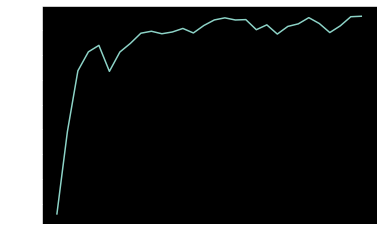

In [17]:
plt.plot(mean_rewards)

# SARSA

In [18]:
class SARSAAgent:
    def __init__(self, n_states, n_actions, gamma, alpha, epsilon, epsilon_min, epsilon_decay):
        self.n_states = n_states
        self.n_actions = n_actions
        self.GAMMA = gamma
        self.ALPHA = alpha
        self.EPSILON = epsilon
        self.epsilon_min = epsilon_min 
        self.epsilon_decay = epsilon_decay
        self.Q = np.zeros((*n_states, n_actions))
        self.bins = self.create_bins()

    # e-GREEDY POLICY
    def get_action(self, state, greedy=False):
        if( (np.random.uniform() >= self.EPSILON) or greedy):
            action = np.argmax(self.Q[state])
        else:
            action = env.action_space.sample()
        return action
    
    # SARSA
    def update_q(self, state, action, reward, state_, action_):
        q_ = self.Q[state_][action_]
        self.Q[state][action] += (self.ALPHA * (reward + (self.GAMMA * q_) - self.Q[state][action]))
        self.decay_epsilon()

    def decay_epsilon(self):
        if(self.EPSILON > self.epsilon_min):
            self.EPSILON = self.EPSILON * self.epsilon_decay
        else:
            self.EPSILON = self.epsilon_min

    # DISCRETIZING CONTINUOUS SPACE
    def create_bins(self):
        bins = [None] * 2
        bins[0] = np.linspace(-1.2, 0.6, self.n_states[0])
        bins[1] = np.linspace(-0.07, 0.07, self.n_states[1])
        return np.array(bins)

    # GIVEN OBSERVATION ARRAY AND BINS, RETURNS STATE NUMBER
    def get_state(self, observation):
        state = [None] * 2
        for i in range(2):
            state[i] = int(np.digitize(observation[i], self.bins[i]) - 1)
        return tuple(state)

In [19]:
#PLAY SINGLE EPISODE - SARSA
def play_episode(agent):
    total_reward = 0

    observation = env.reset()
    state = agent.get_state(observation)
    action = agent.get_action(state)
    
    for moves in range(MAX_MOVES):

        # TAKE ACTION
        observation_, reward, done, _ = env.step(action)
        state_ = agent.get_state(observation_)
        # e-GREEDY
        action_ = agent.get_action(state_)

        total_reward += reward

        # UPDATE Q-VALUES (On policy)
        agent.update_q(state, action, reward, state_, action_)
        
        state, action = state_, action_

        # BREAK IF TERMINATED
        if(done): break 

    return (round(total_reward), round(moves))

In [23]:
# Init
MAX_MOVES = env._max_episode_steps #200
N_STATES = (20, 20)
NUM_EPISODES = 3000

agent = SARSAAgent(n_states = N_STATES,
                   n_actions = env.action_space.n,
                   gamma = 0.90,
                   alpha = 0.1,
                   epsilon = 1.0,
                   epsilon_min = 0.01,
                   epsilon_decay=0.999992)

In [21]:
# TRAINING
episode_rewards = []
episode_lengths = []
mean_rewards = [] # MEAN REWARD OF LAST 100 GAMES

for episode_n in (range(NUM_EPISODES)):
    
    episode_reward, episode_length = play_episode(agent)
    episode_rewards.append(episode_reward)
    episode_lengths.append(episode_length)

    if((episode_n + 1)%100 == 0):
        mean_reward = np.mean(episode_rewards[-100:])
        mean_rewards.append(mean_reward)
        print(" ITER: ",(episode_n),"\tMEAN_RWD: ",mean_reward ,"\tLEN: ",episode_length,"\tEPS: ",round(agent.EPSILON,3))

ITER:  99 	MEAN_REWARD:  -927.68 	EPSILON:  0.4761 	LENGTH:  826
 ITER:  199 	MEAN_REWARD:  -535.43 	EPSILON:  0.3102 	LENGTH:  400
 ITER:  299 	MEAN_REWARD:  -348.42 	EPSILON:  0.2348 	LENGTH:  408
 ITER:  399 	MEAN_REWARD:  -286.35 	EPSILON:  0.1867 	LENGTH:  255
 ITER:  499 	MEAN_REWARD:  -256.24 	EPSILON:  0.1521 	LENGTH:  182
 ITER:  599 	MEAN_REWARD:  -229.87 	EPSILON:  0.1265 	LENGTH:  208
 ITER:  699 	MEAN_REWARD:  -245.88 	EPSILON:  0.1039 	LENGTH:  224
 ITER:  799 	MEAN_REWARD:  -269.07 	EPSILON:  0.0838 	LENGTH:  155
 ITER:  899 	MEAN_REWARD:  -212.04 	EPSILON:  0.0707 	LENGTH:  222
 ITER:  999 	MEAN_REWARD:  -200.71 	EPSILON:  0.0602 	LENGTH:  190
 ITER:  1099 	MEAN_REWARD:  -190.1 	EPSILON:  0.0517 	LENGTH:  221
 ITER:  1199 	MEAN_REWARD:  -197.29 	EPSILON:  0.0442 	LENGTH:  219
 ITER:  1299 	MEAN_REWARD:  -167.2 	EPSILON:  0.0387 	LENGTH:  158
 ITER:  1399 	MEAN_REWARD:  -161.9 	EPSILON:  0.034 	LENGTH:  156
 ITER:  1499 	MEAN_REWARD:  -168.78 	EPSILON:  0.0297 	LENGTH:  

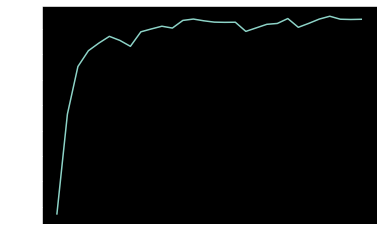

In [22]:
plt.plot(mean_rewards)